# 15 minute city - test

In [67]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Download data from database

In [86]:
year = 2020

#Folder names from database
schema = 'prox_analysis'
hex_folder = 'hex_bins_proximity_2020'

res = 8
c = 'Guadalajara'

In [9]:
query = f"SELECT * FROM {schema}.{hex_folder} WHERE \"metropolis\" LIKE \'{c}\'"
hex_bins = aup.gdf_from_query(query, geometry_col='geometry')

In [10]:
print(hex_bins.shape)
hex_bins.head(2)

(163800, 5)


,hex_id_8,geometry,time,amenity,metropolis
0,8849abc9d1fffff,"POLYGON ((-103.65215 20.42944, -103.65160 20.4...",0.0,sip_centro_admin,Guadalajara
1,8849abc945fffff,"POLYGON ((-103.57671 20.35814, -103.57218 20.3...",0.0,sip_centro_admin,Guadalajara


## Data treatment

### Filter hexagons without data

In [11]:
idx = hex_bins['time']>0
hex_bins = hex_bins.loc[idx]

### Remove duplicate hexagons

In [12]:
hex_bins_geom = hex_bins.drop_duplicates(subset='hex_id_8', keep="last")[['hex_id_8','geometry','metropolis']].copy()
print(hex_bins_geom.shape)
hex_bins_geom.head(2)

(2993, 3)


,hex_id_8,geometry,metropolis
159419,8849abc953fffff,"POLYGON ((-103.61277 20.37822, -103.60824 20.3...",Guadalajara
159707,8849aa26d5fffff,"POLYGON ((-103.57080 20.44003, -103.57533 20.4...",Guadalajara


### Rows to columns

In [13]:
hex_bins_analysis = hex_bins_geom.copy()

for amenidad in list(hex_bins.amenity.unique()):
    hex_tmp = hex_bins.loc[hex_bins.amenity == amenidad,['hex_id_8','time']]
    hex_tmp = hex_tmp.rename(columns={'time':amenidad})
    hex_bins_analysis = hex_bins_analysis.merge(hex_tmp, on='hex_id_8')
    
print(hex_bins_analysis.shape)
hex_bins_analysis.head(2)

(2992, 42)


,hex_id_8,geometry,metropolis,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,...,denue_art_limpieza,denue_pintura,denue_peluqueria,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,sip_mercado,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel
0,8849abc953fffff,"POLYGON ((-103.61277 20.37822, -103.60824 20.3...",Guadalajara,65.318199,69.859240,62.333784,79.503812,90.412665,87.992587,108.843417,...,67.061078,347.501691,59.349050,83.136238,84.384184,63.844640,91.595208,87.441237,333.031638,748.223569
1,8849aa26d5fffff,"POLYGON ((-103.57080 20.44003, -103.57533 20.4...",Guadalajara,110.664398,106.897278,111.302556,102.939897,140.882736,144.485357,171.189859,...,110.630482,180.505948,105.067032,89.956215,119.379762,108.939978,140.882736,111.611614,170.283130,576.011186


<AxesSubplot:>

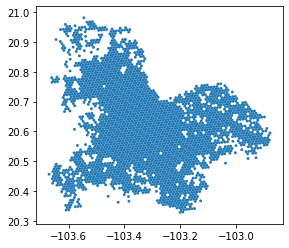

In [15]:
hex_bins_analysis.plot()

## 15 minute analysis

### Parameters definitions

In [61]:
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                         'Primaria':['denue_primaria'],
                         'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                      'Gobierno':['sip_centro_admin'],
                                      'Cuidado':['denue_guarderias','denue_casa_adultos_mayores',
                                                'denue_dif']},
              'Comercio':{'Básicos':['denue_supermercado','denue_abarrotes',
                                    'denue_carnicerias','sip_mercado'],
                         'Personal':['denue_peluqueria','denue_farmacias'],
                         'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                         'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                           'denue_lavanderia','denue_revistas_periodicos',
                                           'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                          'denue_bares','denue_cafe'],
                                'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                   'sip_espacio_publico','denue_parque_natural'],
                                'Cultural':['denue_cines','denue_museos']} 
             }

wegiht_idx = {'Escuelas':{'Preescolar':0.333,
                         'Primaria':0.333,
                         'Secundaria':0.333},
             'Servicios comunitarios':{'Salud':0.333,
                                      'Gobierno':0.333,
                                      'Cuidado':0.333},
              'Comercio':{'Básicos':0.3,
                         'Personal':0.3,
                         'Hogar':0.3,
                         'Complementarios':0.1},
              'Entretenimiento':{'Social':0.333,
                                'Actividad física':0.333,
                                'Cultural':0.333}
             }

tiempos_15_min = {'denue_preescolar':[5,'peatonal'],
                 'denue_primaria':[5,'peatonal'],
                 'denue_secundaria':[15,'peatonal'],
                  'denue_escuela_mixta':[15,'peatonal'],
                 'clues_primer_nivel':[5,'peatonal'],
                 'sip_centro_admin':[15,'bicicleta'],
                 'denue_guarderias':[10,'peatonal'],
                 'denue_casa_adultos_mayores':[5,'peatonal'],
                 'denue_dif':[15,'bicicleta'],
                 'denue_supermercado':[5,'peatonal'],
                 'denue_abarrotes':[5,'peatonal'],
                 'denue_carnicerias':[5,'peatonal'],
                 'sip_mercado':[5,'peatonal'],
                 'denue_peluqueria':[15,'bicicleta'],
                  'denue_farmacias':[15,'peatonal'],
                  'denue_ferreteria_tlapaleria':[15,'peatonal'],
                  'denue_art_limpieza':[15,'peatonal'],
                  'denue_ropa':[15,'peatonal'],
                  'denue_calzado':[15,'peatonal'],
                  'denue_muebles':[15,'peatonal'],
                  'denue_lavanderia':[15,'peatonal'],
                  'denue_revistas_periodicos':[15,'peatonal'],
                  'denue_pintura':[15,'peatonal'],
                  'denue_restaurante_insitu':[15,'peatonal'],
                  'denue_restaurante_llevar':[15,'peatonal'],
                  'denue_bares':[15,'peatonal'],
                  'denue_cafe':[15,'peatonal'],
                  'sip_cancha':[5,'peatonal'],
                  'sip_unidad_deportiva':[5,'peatonal'],
                  'sip_espacio_publico':[5,'peatonal'],
                  'denue_parque_natural':[15,'bicicleta'],
                  'denue_cines':[15,'bicicleta'],
                  'denue_museos':[15,'bicicleta']
                 }

### Analysis

In [62]:
hex_15_min = hex_bins_analysis.copy()

for amenidad in list(tiempos_15_min.keys()):
    idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
    hex_15_min[idx_column_name] = 0
    
    if tiempos_15_min[amenidad][1] == 'peatonal':
        tiempo_limite = tiempos_15_min[amenidad][0]
    else:
        tiempo_limite = tiempos_15_min[amenidad][0] * 3
        
    idx_amenidad = hex_15_min[amenidad] <= tiempo_limite
    hex_15_min.loc[idx_amenidad, idx_column_name] = 1
    

In [63]:
cat_list = []
raw_cat_list = []

for cat in idx_15_min.keys():
    
    cat_list.append(cat)
    raw_cat_list.append('raw_'+cat)
    
    subcat_list = []
    
    for subcat in idx_15_min[cat]:
        
        subcat_list.append(subcat)
                
        subcat_amenities_list = []
        
        for amenidad in idx_15_min[cat][subcat]:
            
            idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
            subcat_amenities_list.append(idx_column_name)
            
        hex_15_min['raw_'+subcat] = (hex_15_min[subcat_amenities_list].sum(axis=1) / len(subcat_amenities_list)) * wegiht_idx[cat][subcat]
        
        idx = hex_15_min['raw_'+subcat] > 0
        hex_15_min[subcat] = 0
        hex_15_min.loc[idx, subcat] = 1 * wegiht_idx[cat][subcat]
        
    hex_15_min[cat] = hex_15_min[subcat_list].sum(axis=1)
    hex_15_min['raw_'+cat] = hex_15_min[subcat_list].sum(axis=1)
    
hex_15_min['15_min_analysis'] = hex_15_min[cat_list].sum(axis=1)
hex_15_min['raw_15_min_analysis'] = hex_15_min[raw_cat_list].sum(axis=1)

            

In [72]:
hex_15_min['15_min_analysis']

0       0.000
1       0.000
2       1.299
3       1.299
4       1.999
        ...  
2987    0.000
2988    0.000
2989    0.333
2990    0.000
2991    0.333
Name: 15_min_analysis, Length: 2992, dtype: float64

(-103.71471496005557,
 -102.83380358956258,
 20.29070243473398,
 21.018919525455594)

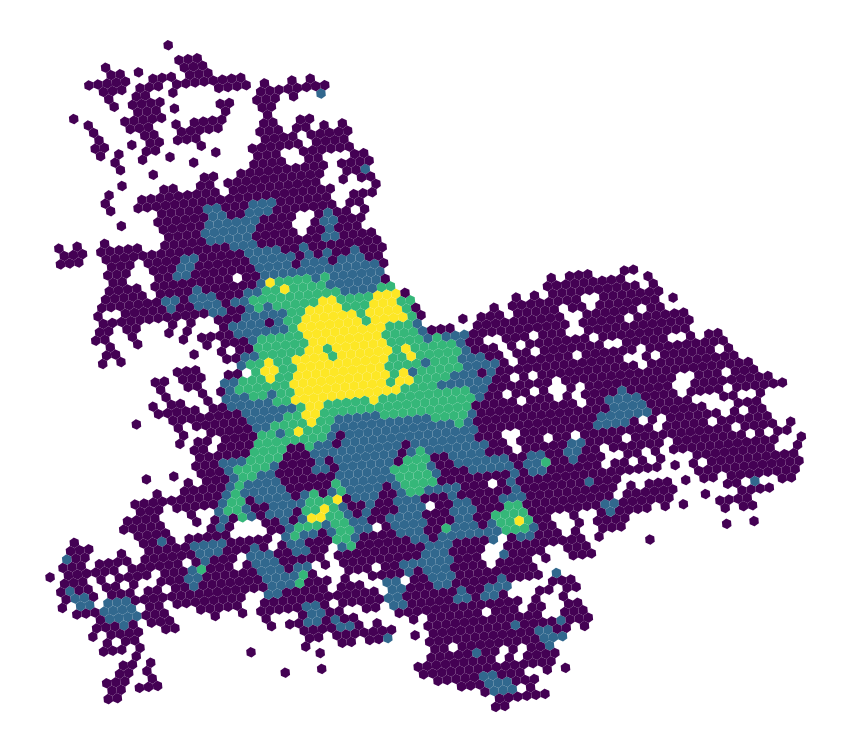

In [83]:
fig, ax = plt.subplots(figsize=(15,15))


hex_15_min.plot('raw_Entretenimiento',ax=ax)

ax.axis('off')

In [84]:
hex_15_min

0       0.000
1       0.000
2       0.333
3       0.333
4       0.333
        ...  
2987    0.000
2988    0.000
2989    0.000
2990    0.000
2991    0.000
Name: raw_Entretenimiento, Length: 2992, dtype: float64

In [87]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Ciudad_15_min/'
hex_15_min.to_file(grl_dir+f'Medio_Urbano/Analisis/{c}_15min_Analisis_res{res}.geojson', driver='GeoJSON')